## imports / setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from pathlib import Path
import torch
from torch import optim, nn
import PIL 
import pydicom

from functools import partial, reduce
from enum import Enum

In [3]:
# helper function from the competition
import mask_functions

# helpers

In [4]:
def ls(p, re='*'):
    return [i for i in p.glob(re)]

In [78]:
def getImg(fpath):
    ds = pydicom.read_file( fpath) # read dicom image
    return ds.pixel_array, ds # get image array
    
def getMask(imgId, df, shape):
    """returns nd array mask"""
    df = df.loc[df['ImageId'] == imgId]
    rle_r = df['EncodedPixels'].tolist()
    
    rle = ''
    if len(rle_r) > 0:
        rle = rle_r[0].strip()

    mask = np.zeros([*shape])
    if not rle == ' -1':
        mask = mask_functions.rle2mask(rle, *shape)
        mask = np.flip(mask, axis=0)
        mask = np.rot90(mask, -1)
    return mask

def getImageAndMask(fname, labels):
    imgf = fname 
    imgPath = str(imgf)
    imgId = imgf.stem
    img,_ = getImg( imgPath )
    mask = getMask(imgId, df=labels, shape=img.shape)
    return img, mask

In [79]:
def plot_multi(fn, size=[1,1], item_list=[]):
    fig, ax = plt.subplots(size[0],size[1], figsize=(40,60))
    
    ax = ax.flatten()
    for idx, a in enumerate(ax):
        if not idx > (len(item_list)-1):
            item = item_list[idx]
            fn(a, item)
                 
def plot_xray_mask(a, item, df, show_mask=True):
    img, mask = getImageAndMask(item, labels=df)
    a.imshow(img, cmap=plt.cm.bone)
    # if mask
    if not np.all(mask == 0): 
        a.set_title('Pneumothorax Present')
        a.imshow(mask, alpha=0.3, cmap='Reds')
        
def plot_xray(a, img):
    a.imshow(img, cmap=plt.cm.bone)

detach = lambda ten: ten.detach().numpy()[0]
    
def plot_xyhat(arr):
    item_list =[ detach(x) for x in arr ]

    plot_multi(plot_xray, size=[1,3], item_list=item_list)

# full data path!

In [80]:
# get sample data
path = Path('/home/ubuntu/data/fastai/data/siim-acr/')

In [81]:
fnames = []
for p in ls(path/'dicom-images-train'):
#     print(ls(p))
    for pp in ls(p):
#         print(len(ls(pp)))
        fnames.append(*ls(pp))

In [82]:
labels_path = path/'train-rle.csv'

In [83]:
labelsdf = pd.read_csv(labels_path).rename(columns={' EncodedPixels':'EncodedPixels'})

# Dataloader

In [11]:
from torch.utils.data import Dataset, dataloader

In [12]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
# lazy load the masks and images
class Xray(Dataset):
    def __init__(self):
        self.len = len(fnames)
        
    def __getitem__(self, index):
        x,y = getImageAndMask(fnames[index], labelsdf)
        x = torch.Tensor(x).view(1, 1024, 1024).to(dev)
        y = torch.Tensor(y).view(1, 1024, 1024).to(dev)
        return x, y
        
    def __len__(self):
        return self.len
    

In [14]:
ds = Xray()

In [15]:
ds[149]

(tensor([[[ 1.,  1.,  1.,  ...,  0.,  0.,  0.],
          [ 1.,  1.,  1.,  ...,  0.,  0.,  0.],
          [ 1.,  1.,  1.,  ...,  0.,  0.,  0.],
          ...,
          [ 4., 12., 13.,  ...,  0.,  0.,  0.],
          [ 4., 10., 12.,  ...,  0.,  0.,  0.],
          [ 3.,  5.,  7.,  ...,  0.,  0.,  0.]]], device='cuda:0'),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'))

In [16]:
dl = dataloader.DataLoader(ds, batch_size=64, shuffle=True, num_workers=0)

In [17]:
dli = iter(dl)

In [18]:
xb, yb = next(dli)

In [19]:
xb.shape, xb.view([1,-1]).shape[1]

(torch.Size([64, 1, 1024, 1024]), 67108864)

In [20]:
 xb[0].view([1,-1]).view([1,1024,1024]).dim()

3

In [21]:
xb[0].view([1,-1]).dim()

2

In [22]:
xb, yb = next(dli)

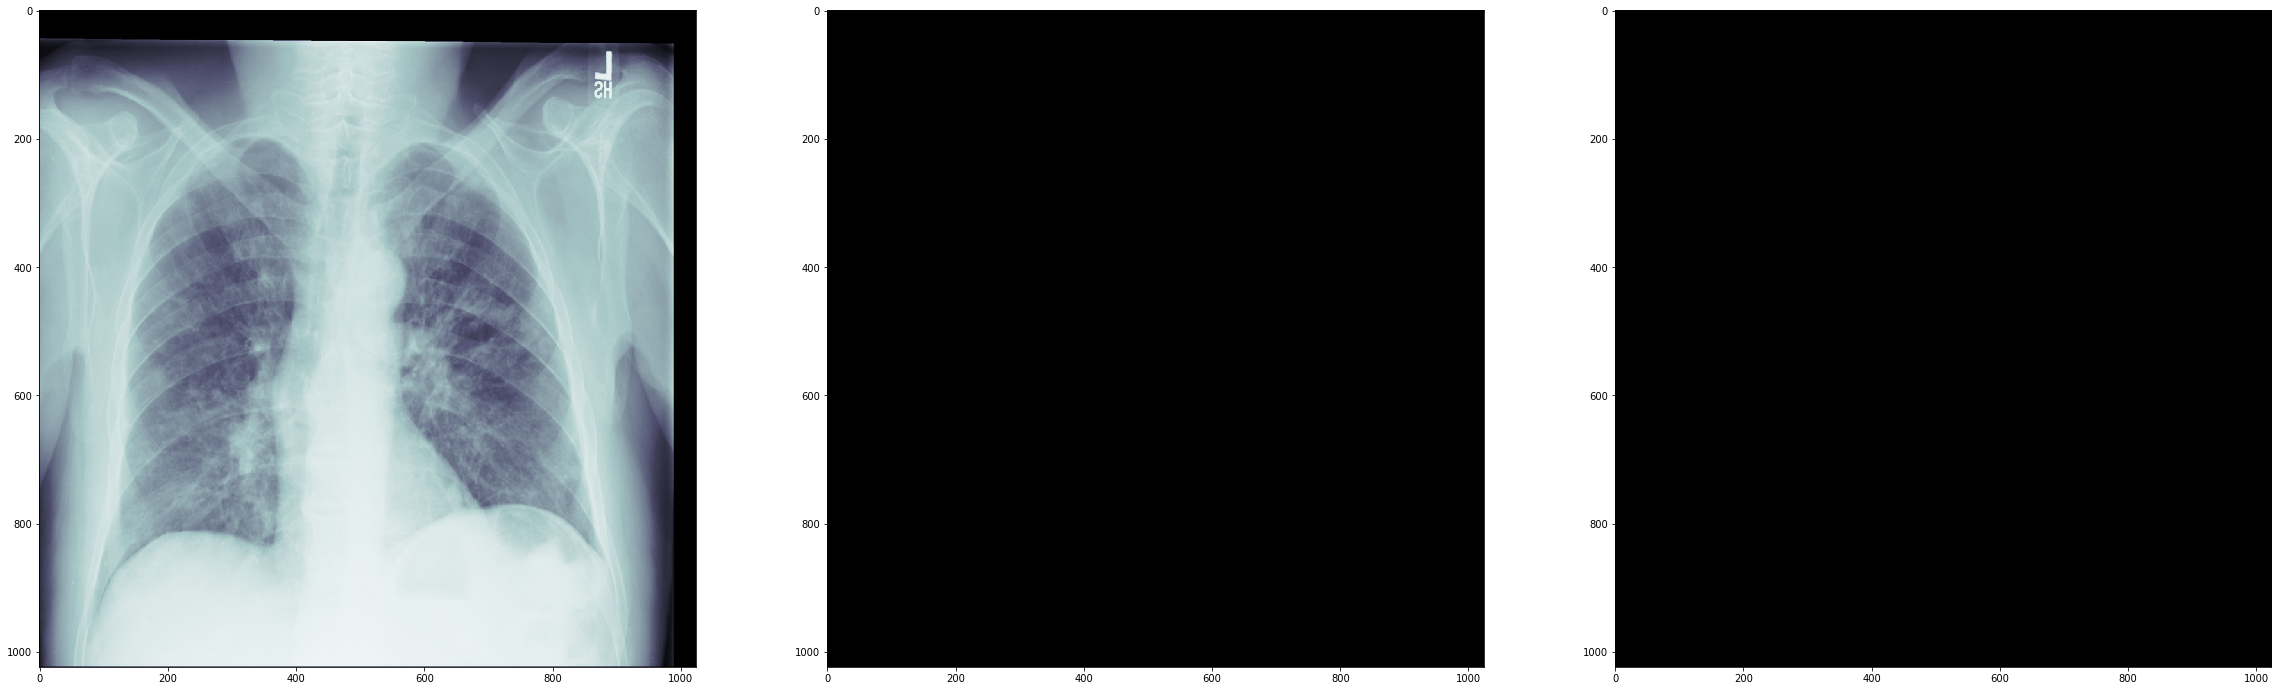

In [23]:
plot_xyhat([x.cpu()[0] for x in  [xb, yb, yb]])

In [52]:
ln = len(fnames);ln

10712

In [53]:
trn_split = int(ln*0.8)

In [54]:
trn_fnames = fnames[0:trn_split]
trn_l = len(trn_fnames)

In [64]:
val_fnames = fnames[trn_split:]
val_l = len(val_fnames)

In [65]:
(trn_l + val_l) == ln

True

In [70]:
val_fnames[0] == trn_fnames[-1]

False

In [73]:
df = labelsdf

In [85]:
df.loc[df['EncodedPixels'] != ' -1'].shape

(3286, 2)

In [86]:
8296 + 3286

11582